In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import ipyvolume as ipv

In [474]:
import kelp_compute
import kelp_analyze
import discrete_plot
import error_visualize

In [6]:
import sqlite3
import shutil
import os

In [341]:
def cori_get_fd_vs_best_grid_study_onespace_errors(study_name):
    base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
    study_dir = os.path.join(base_dir, study_name)
    db_path = os.path.join(study_dir, '{}.db'.format(study_name))
    perceived_irrad_dict, abs_err_arr, rel_err_arr, compute_time_dict = (
        kelp_analyze.grid_study_analyze_fd_vs_best_onespace(db_path, study_name)
    )
    
    # TODO: Do plot, not just return errors
    #return ipv.quickvolshow(abs_err_arr),
    return abs_err_arr, rel_err_arr

In [342]:
def cori_get_fd_vs_noscat_grid_study_onespace_errors(study_name):
    base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
    study_dir = os.path.join(base_dir, study_name)
    db_path = os.path.join(study_dir, '{}.db'.format(study_name))
    perceived_irrad_dict, abs_err_arr, rel_err_arr, compute_time_dict = (
        kelp_analyze.grid_study_analyze_fd_vs_noscat_onespace(db_path, study_name)
    )
    
    # TODO: Do plot, not just return errors
    #return ipv.quickvolshow(abs_err_arr),
    return abs_err_arr, rel_err_arr

# General

## Compare Two

abs_err = 8.126e-02
rel_err = 1.391e-02


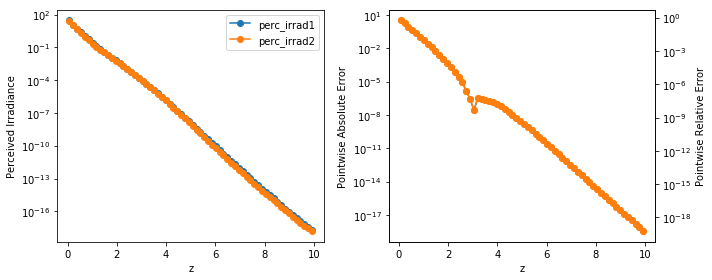

In [463]:
kelp_analyze.cori_plot_two_avg_irrads_onespace(
    'gs64_top_heavy',
    {'ns': 64, 'na': 10, 'fd_flag': True},
    {'ns': 64, 'na': 10, 'fd_flag': False},
    plot_err=True,
    log_data=True
)

# FD vs. True ($b=0$)

## Converging

```
a = 0.1
b = 0.0
top-heavy
```

In [477]:
ns_list = np.arange(8, 89, 8)
na_list = np.arange(2, 9, 2)
study_name = 'gs88_a01_b0'

In [478]:
abs_err_arr, rel_err_arr = cori_get_fd_vs_noscat_grid_study_onespace_errors(study_name)

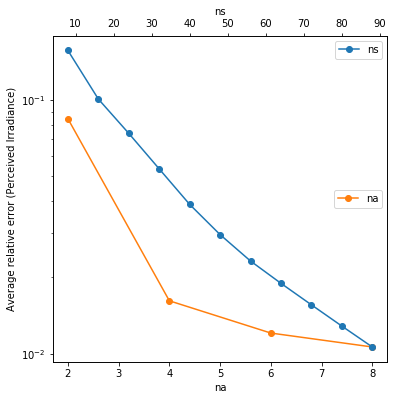

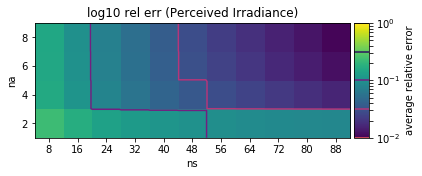

In [479]:
plot_gs_edges_and_grid(rel_err_arr, abs_err_arr, ns_list, na_list)

## Non-converging

```
a = 0.1
b = 0.0
top-heavy
```

In [483]:
ns_list = np.arange(8, 16)
na_list = np.arange(2, 11, 2)
study_name = 'gs23_a01_b0'

In [484]:
abs_err_arr, rel_err_arr = cori_get_fd_vs_noscat_grid_study_onespace_errors(study_name)

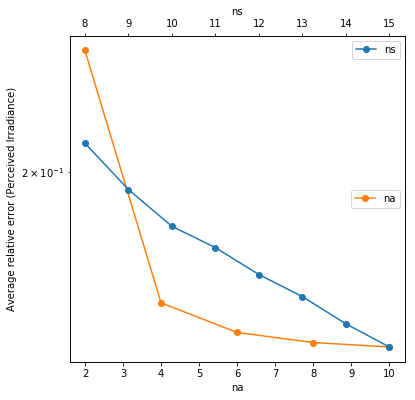

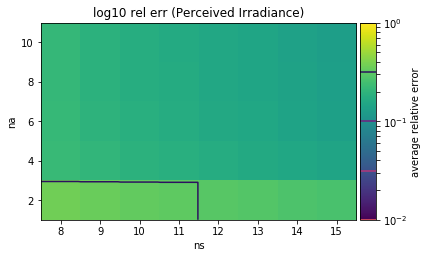

In [485]:
error_visualize.plot_gs_edges_and_grid(rel_err_arr[:8,:], abs_err_arr[:8,:], ns_list, na_list)

##  $a_w \gg 1$

```
a = 5.0
b = 0.0
top-heavy
```

In [216]:
ns_list = np.arange(8, 65, 8)
na_list = np.arange(2, 11, 2)
study_name = 'gs64_a50_b0'

In [217]:
abs_err_arr, rel_err_arr = cori_get_fd_vs_noscat_grid_study_onespace_errors(study_name)

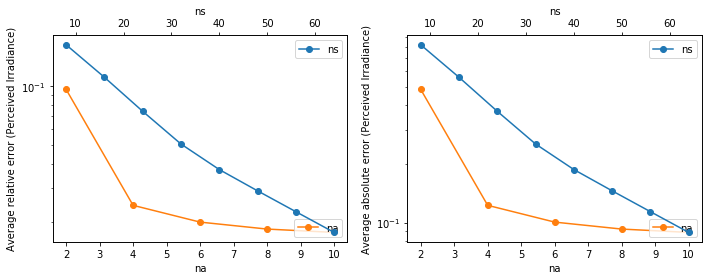

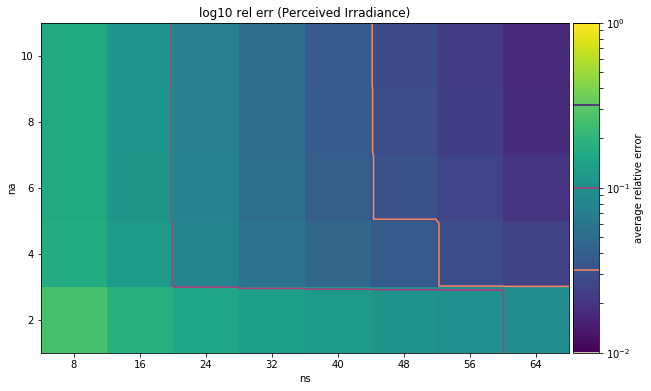

In [218]:
plot_gs_edges_and_grid(rel_err_arr, abs_err_arr, ns_list, na_list)

##  Bottom-heavy

```
a = 0.1
b = 0.0
bottom-heavy
```

In [219]:
ns_list = np.arange(8, 65, 8)
na_list = np.arange(2, 11, 2)
study_name = 'gs64_a01_b0_bh'

In [220]:
abs_err_arr, rel_err_arr = cori_get_fd_vs_noscat_grid_study_onespace_errors(study_name)

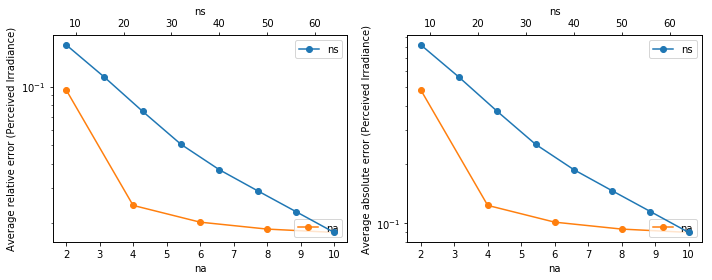

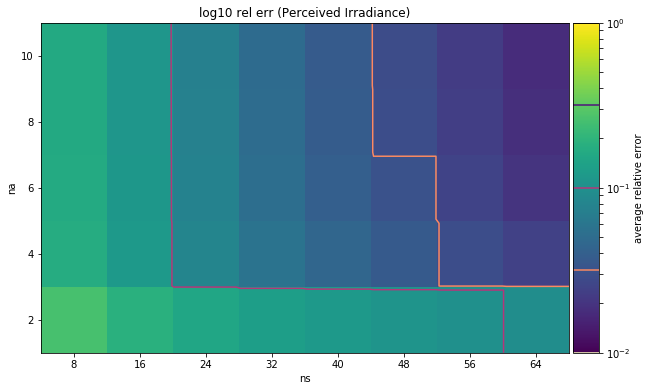

In [221]:
plot_gs_edges_and_grid(rel_err_arr, abs_err_arr, ns_list, na_list)

# FD vs. FD

## Converging, $b=0$

```
a = 0.1
b = 0.0
top-heavy
```

In [304]:
ns_list = np.arange(8, 89, 8)
na_list = np.arange(2, 9, 2)
study_name = 'gs88_a01_b0'

In [305]:
abs_err_arr, rel_err_arr = cori_get_fd_vs_best_grid_study_onespace_errors(study_name)

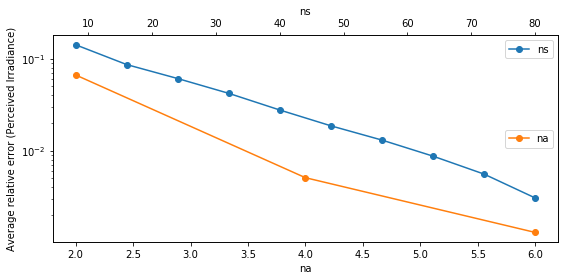

/global/homes/o/oevans/local/miniconda3/envs/kelp/lib/python3.6/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


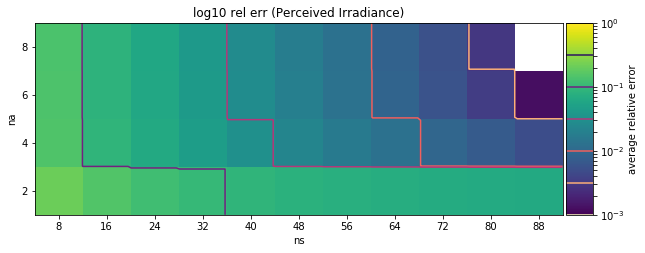

In [306]:
plot_gs_edges_and_grid(rel_err_arr, abs_err_arr, ns_list, na_list)

## Non-converging, $b=0$

```
a = 0.1
b = 0.0
top-heavy
```

In [326]:
ns_list = np.arange(8, 16)
na_list = np.arange(2, 11, 2)
study_name = 'gs64_a01_b0_small'

In [327]:
abs_err_arr, rel_err_arr = cori_get_fd_vs_best_grid_study_onespace_errors(study_name)

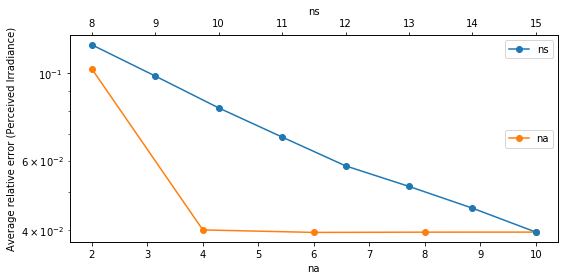

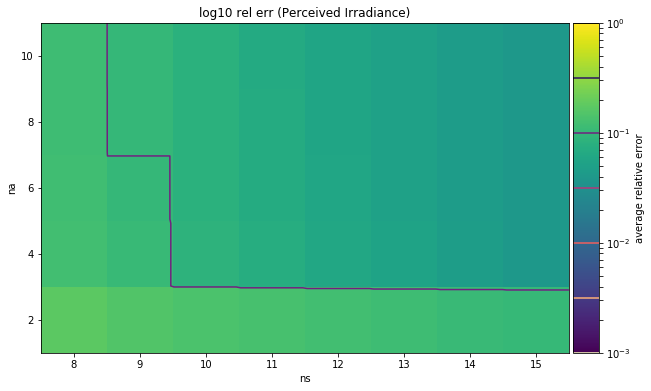

In [331]:
plot_gs_edges_and_grid(rel_err_arr[:8,:], abs_err_arr[:8,:], ns_list, na_list)

## $b \neq 0$

```
a = 0.179
b = 0.217
top-heavy
```

In [255]:
ns_list = np.arange(8, 65, 8)
na_list = np.arange(2, 11, 2)
study_name = 'gs64_top_heavy'

In [256]:
abs_err_arr, rel_err_arr = cori_get_fd_vs_best_grid_study_onespace_errors(study_name)

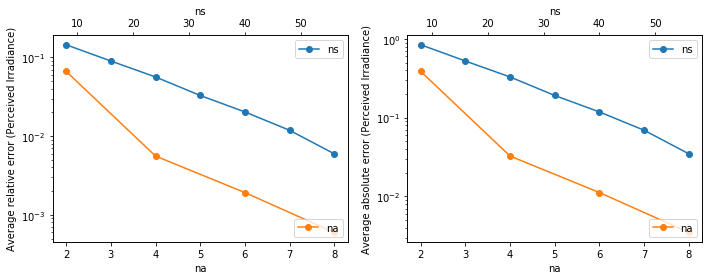

/global/homes/o/oevans/local/miniconda3/envs/kelp/lib/python3.6/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


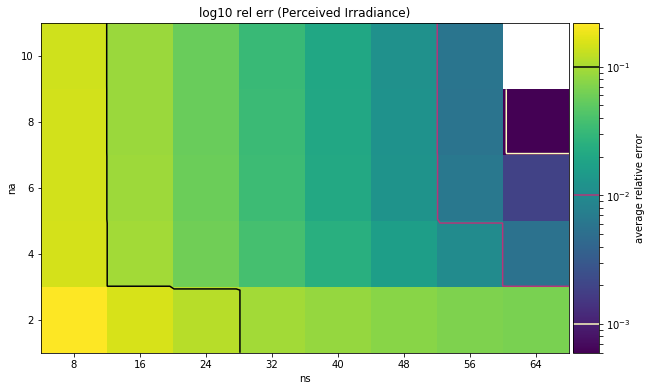

In [257]:
plot_gs_edges_and_grid(rel_err_arr, abs_err_arr, ns_list, na_list)

## $b \gg 1$

```
a = 0.337
b = 1.583
top-heavy
```

In [258]:
ns_list = np.arange(8, 65, 8)
na_list = np.arange(2, 11, 2)
study_name = 'gs64_nuc2200'

In [259]:
abs_err_arr, rel_err_arr = cori_get_fd_vs_best_grid_study_onespace_errors(study_name)

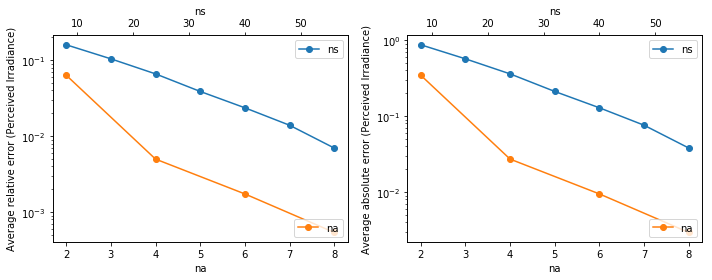

/global/homes/o/oevans/local/miniconda3/envs/kelp/lib/python3.6/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


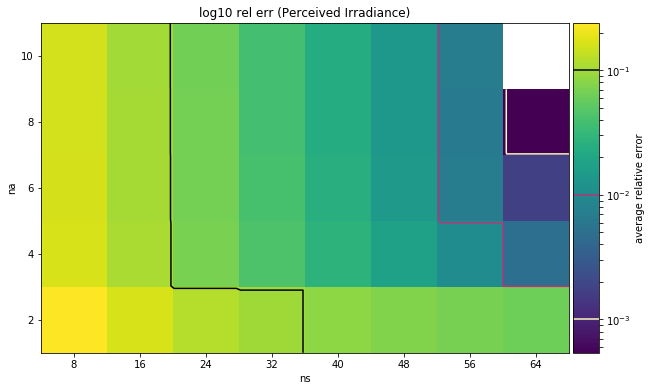

In [260]:
plot_gs_edges_and_grid(rel_err_arr, abs_err_arr, ns_list, na_list)